In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length,data):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs




def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length,data)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData


data=[]
filePrefix="data/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue

    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))
data = removeDuplicateRuns(data)

roughData=[]
for name in glob.glob("roughIslandData/*.out"):
    thisData=loadFile(name+"/table.txt")
    desc=name[len("roughIslandData/"):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    roughData.append(thisData)
roughPointinessVals, roughSpacingVals, roughLengthVals = getPossibleVals(roughData)

                


for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length,data)
                if len(runs)>1:
                    print(pointiness,spacing,length)
                    raise Exception()

                    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

Could not load data/p0.out
([0.0, 0.1, 0.2, 0.26667, 0.2963, 0.3, 0.34783, 0.4, 0.44444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06], [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07])
Inconsistent data for 0.1, 3.0000000000000004e-07, 1.8000000000000002e-07
Inconsistent data for 0.1, 3.0000000000000004e-07, 2.0000000000000002e-07
Inconsistent data for 0.1, 3.4000000000000003e-07, 2.3000000000000002e-07
Inconsistent data for 0.1, 3.8e-07, 2.7e-07
Inconsistent data for 0.2, 3.2e-07, 2.3000000000000002e-07
Inconsistent data for 0.6, 4.0000000000000003e-07, 2.0000000000000002e-07
Fixed data for 46/505 runs. 6 runs unfixable, 0 not enough data


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2]:
"""for p in roughPointinessVals:
    for l in roughLengthVals:
        for a in roughSpacingVals:
            runs=getRuns(a,p,l,roughData)
            realRun=getRuns(a,p,l,data)
            if len(realRun)==0: continue
            else: realRun=realRun[0]
            print(len)
            plt.plot(realRun["H"],realRun["m"],color="k")
            for run in runs:
                plt.plot(run["H"],run["m"])
            plt.show()"""


print("ROUGH DATA")
print("a",roughSpacingVals)
print("p",roughPointinessVals)
print("l",roughLengthVals)

print("SMOOTH DATA")
print("a",spacingVals)
print("p",pointinessVals)
print("l",lengthVals)

ROUGH DATA
a [2.8e-07, 3.2e-07, 3.4000000000000003e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 8.000000000000001e-07]
p [0.1, 0.5, 0.8]
l [1.8000000000000002e-07, 2.3000000000000002e-07, 3.0000000000000004e-07]
SMOOTH DATA
a [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06]
p [0.0, 0.1, 0.2, 0.26667, 0.2963, 0.3, 0.34783, 0.4, 0.44444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
l [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07]


/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_11213/3792476309.py:70: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))


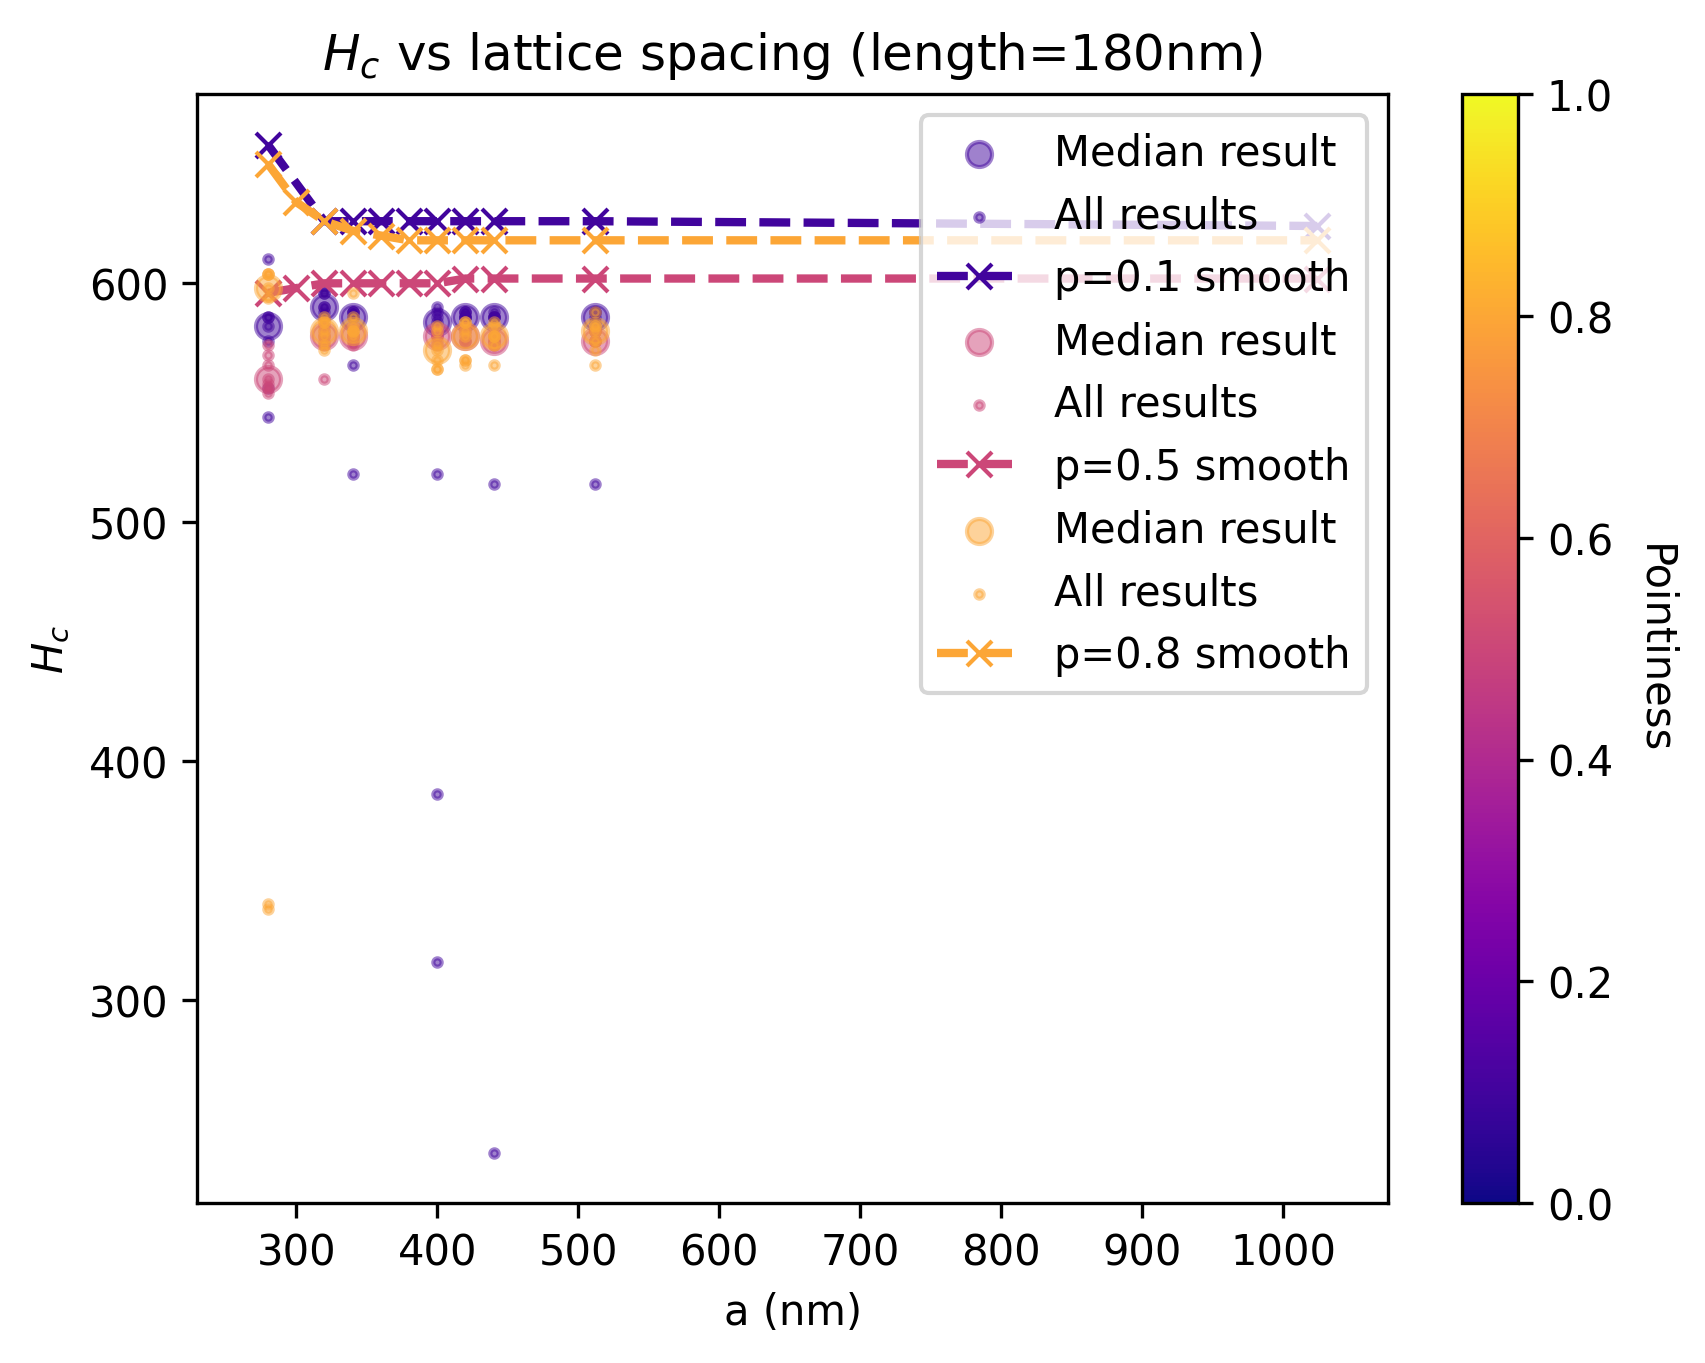

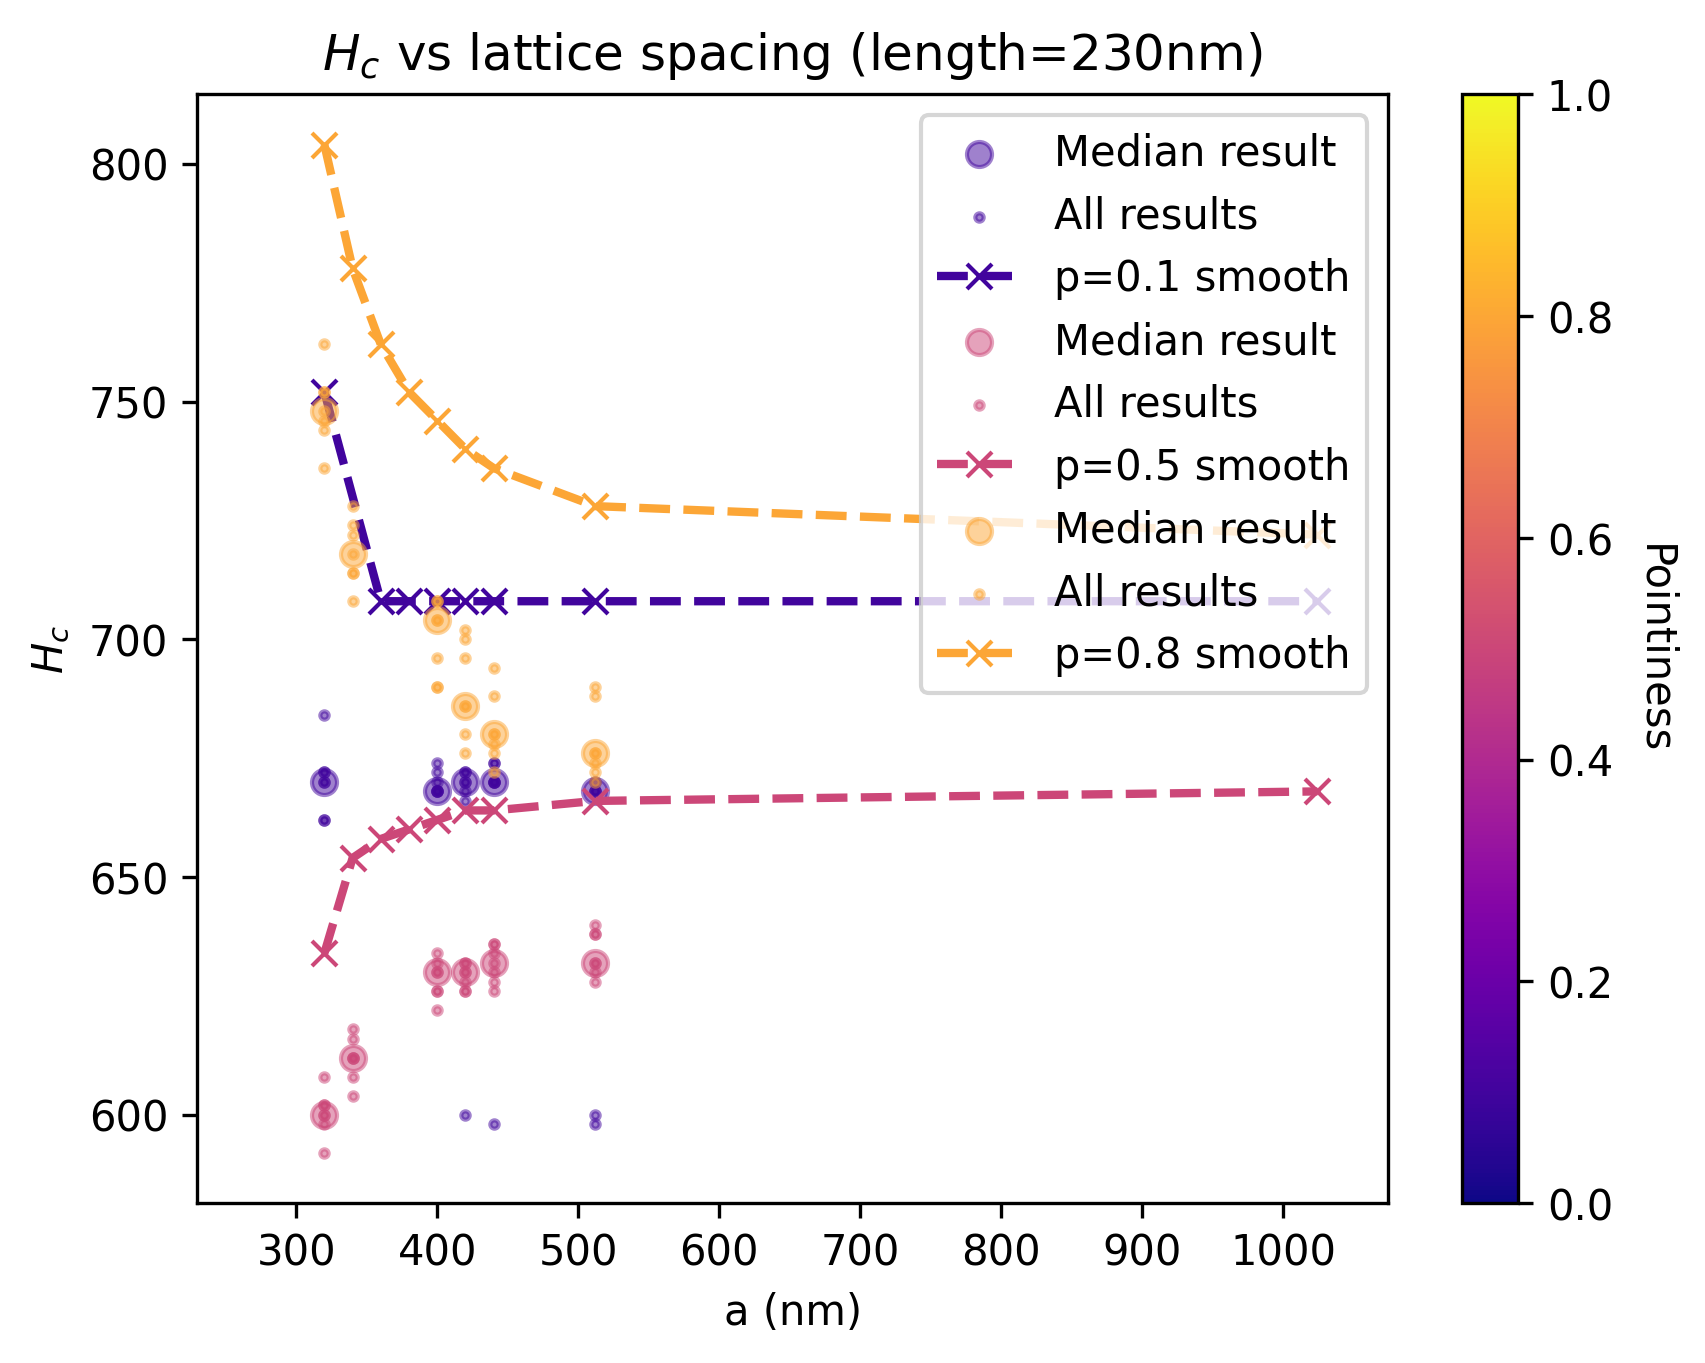

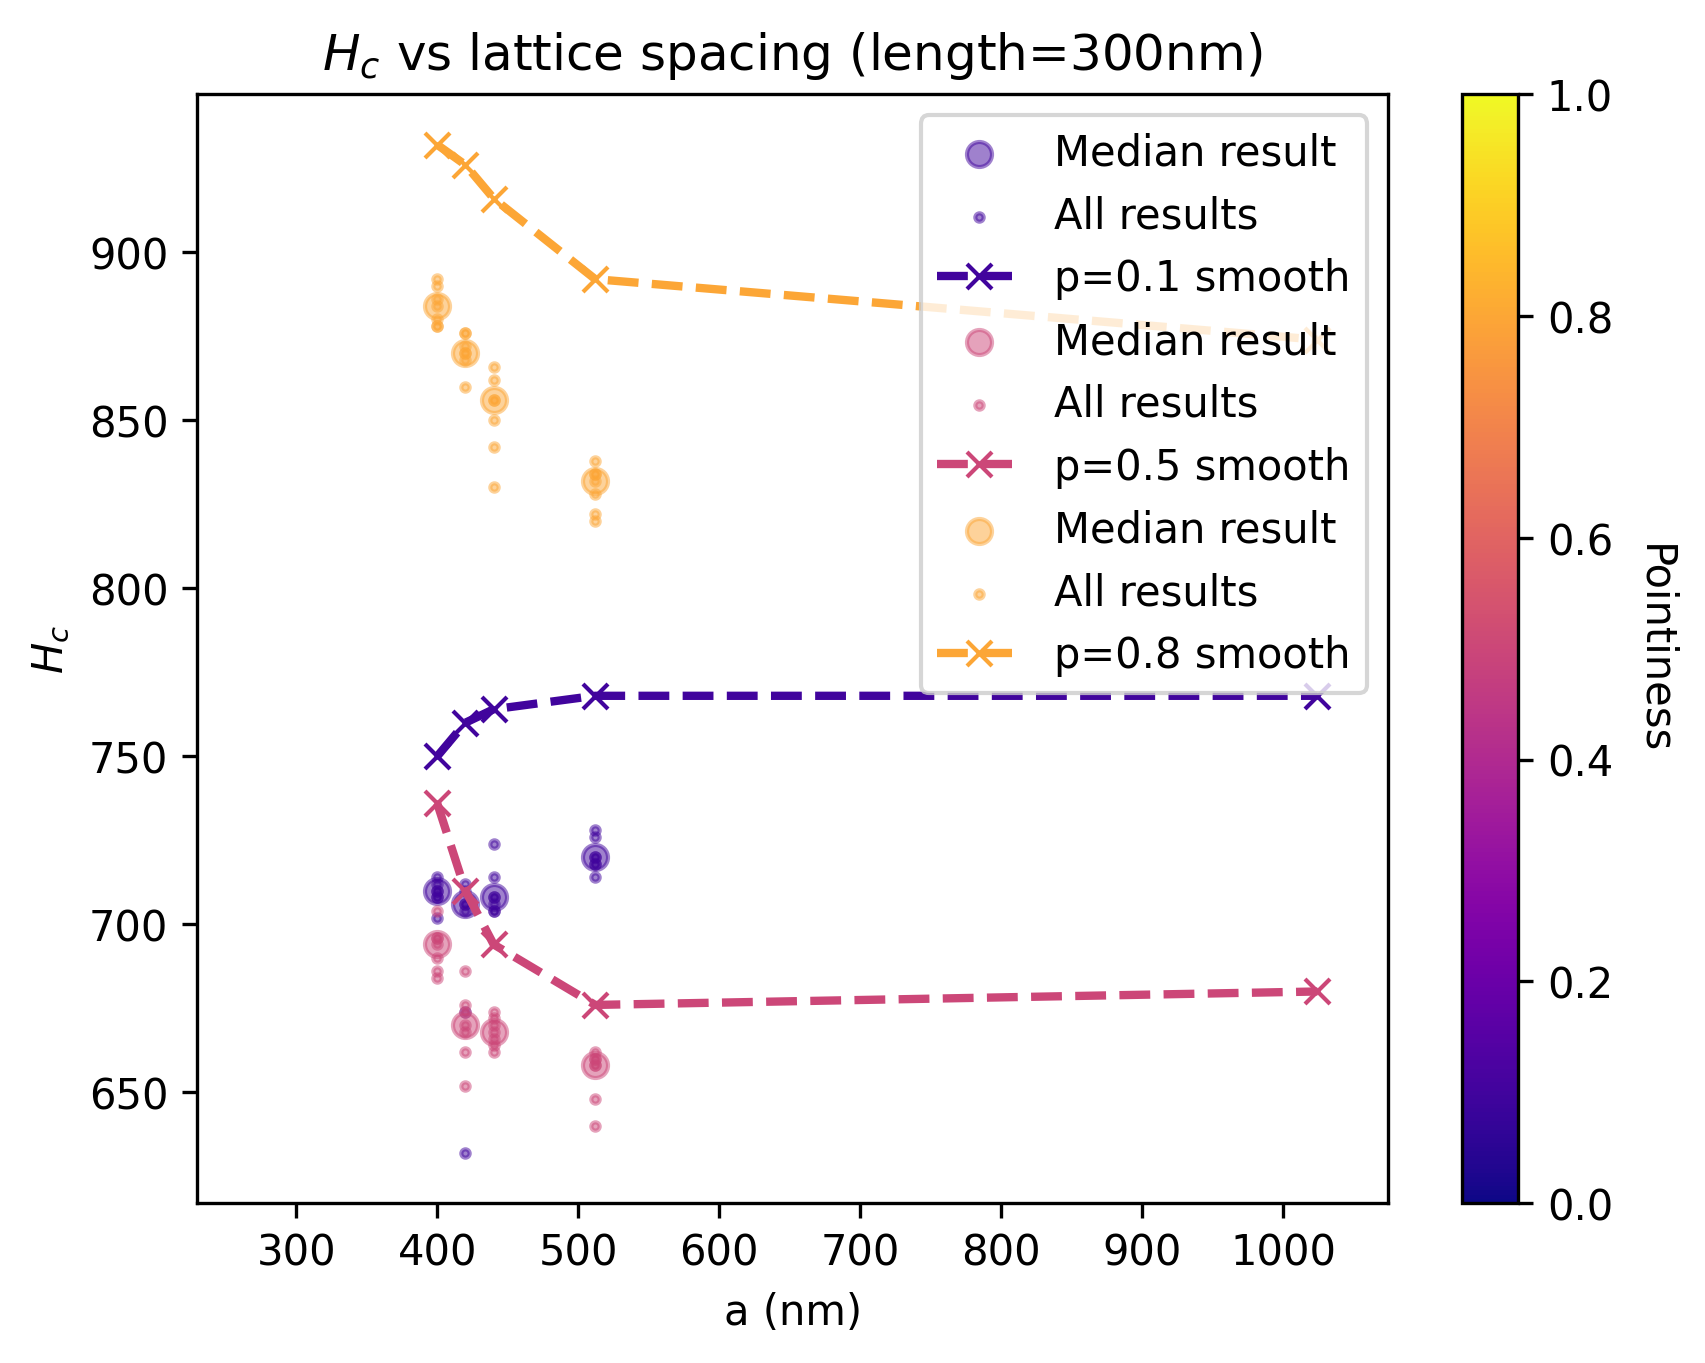

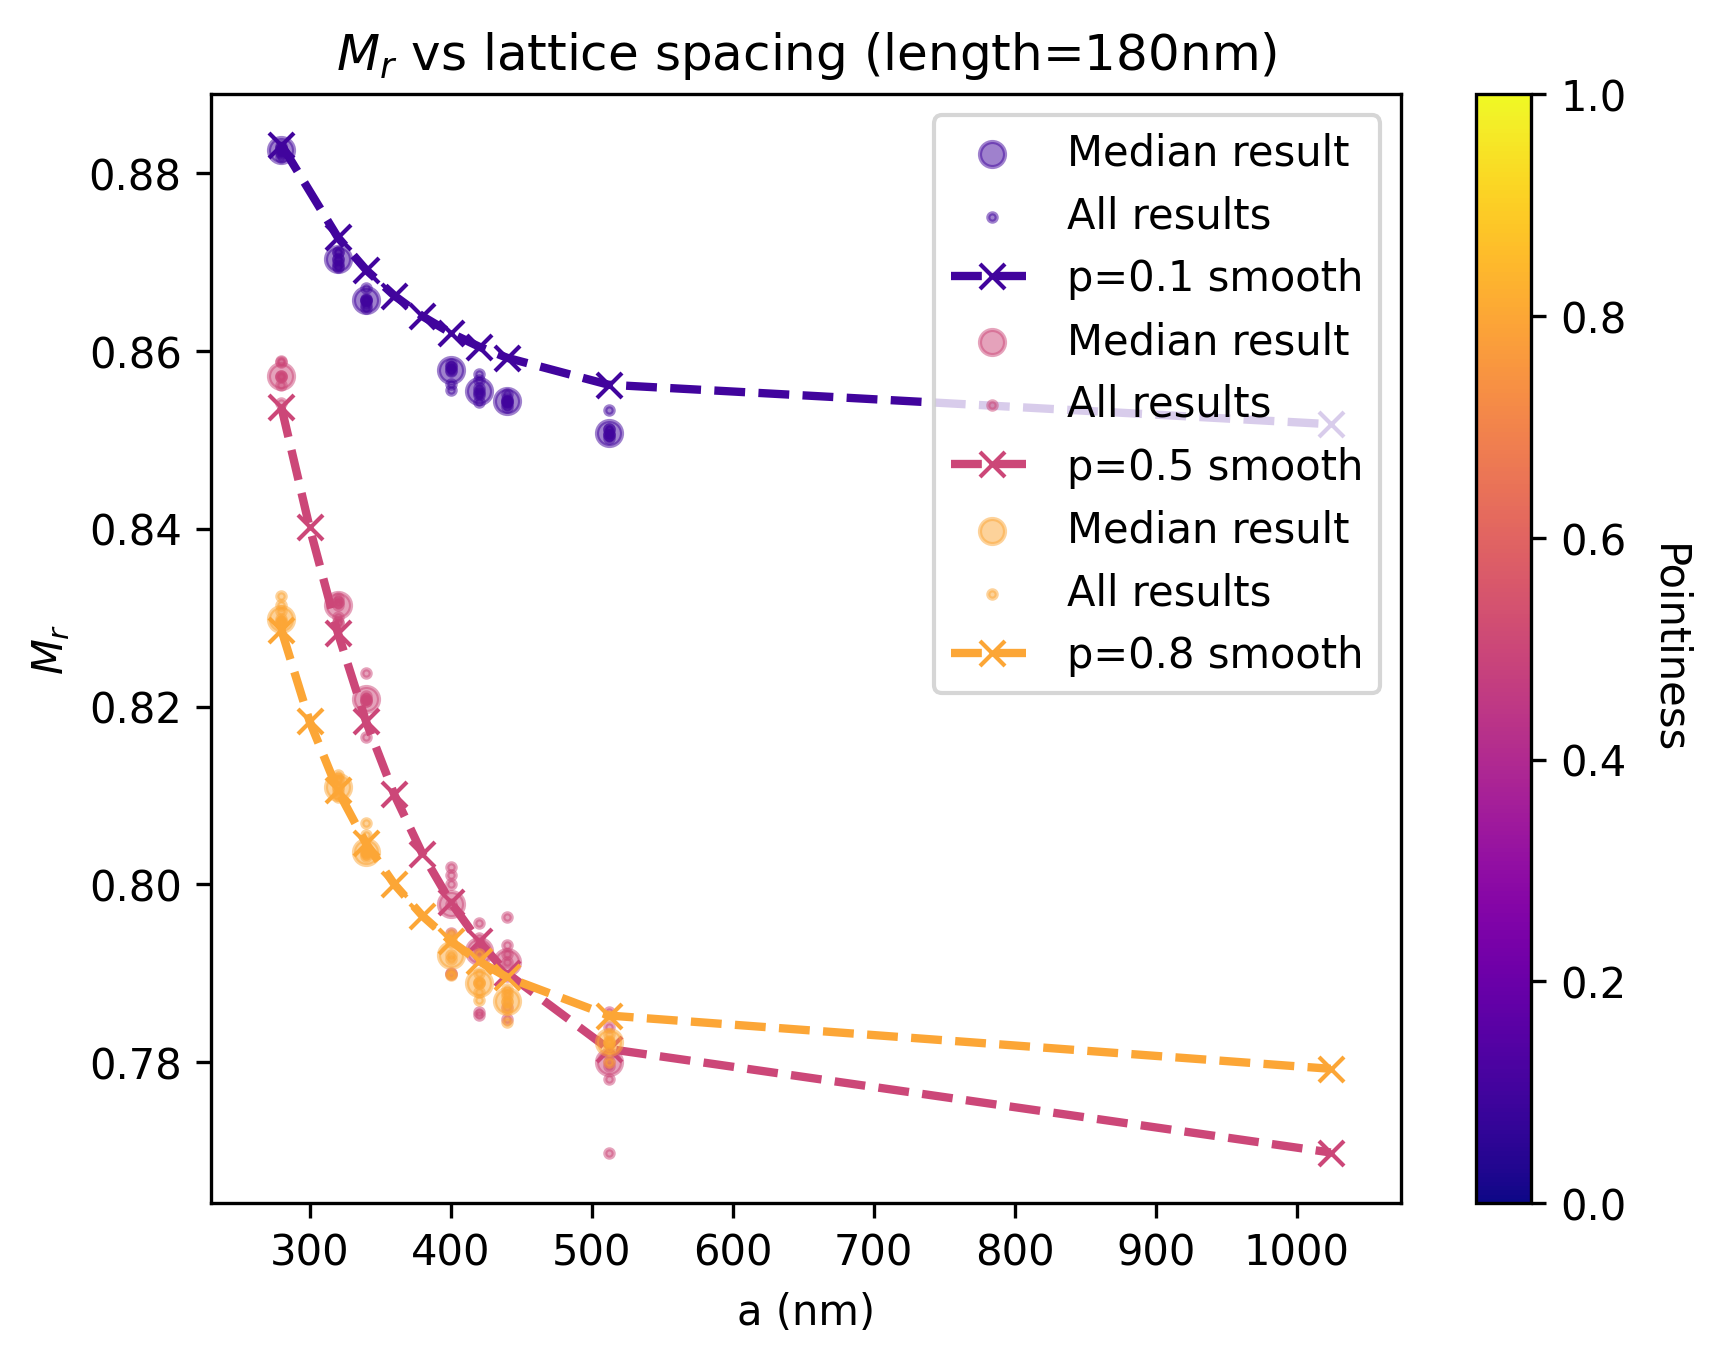

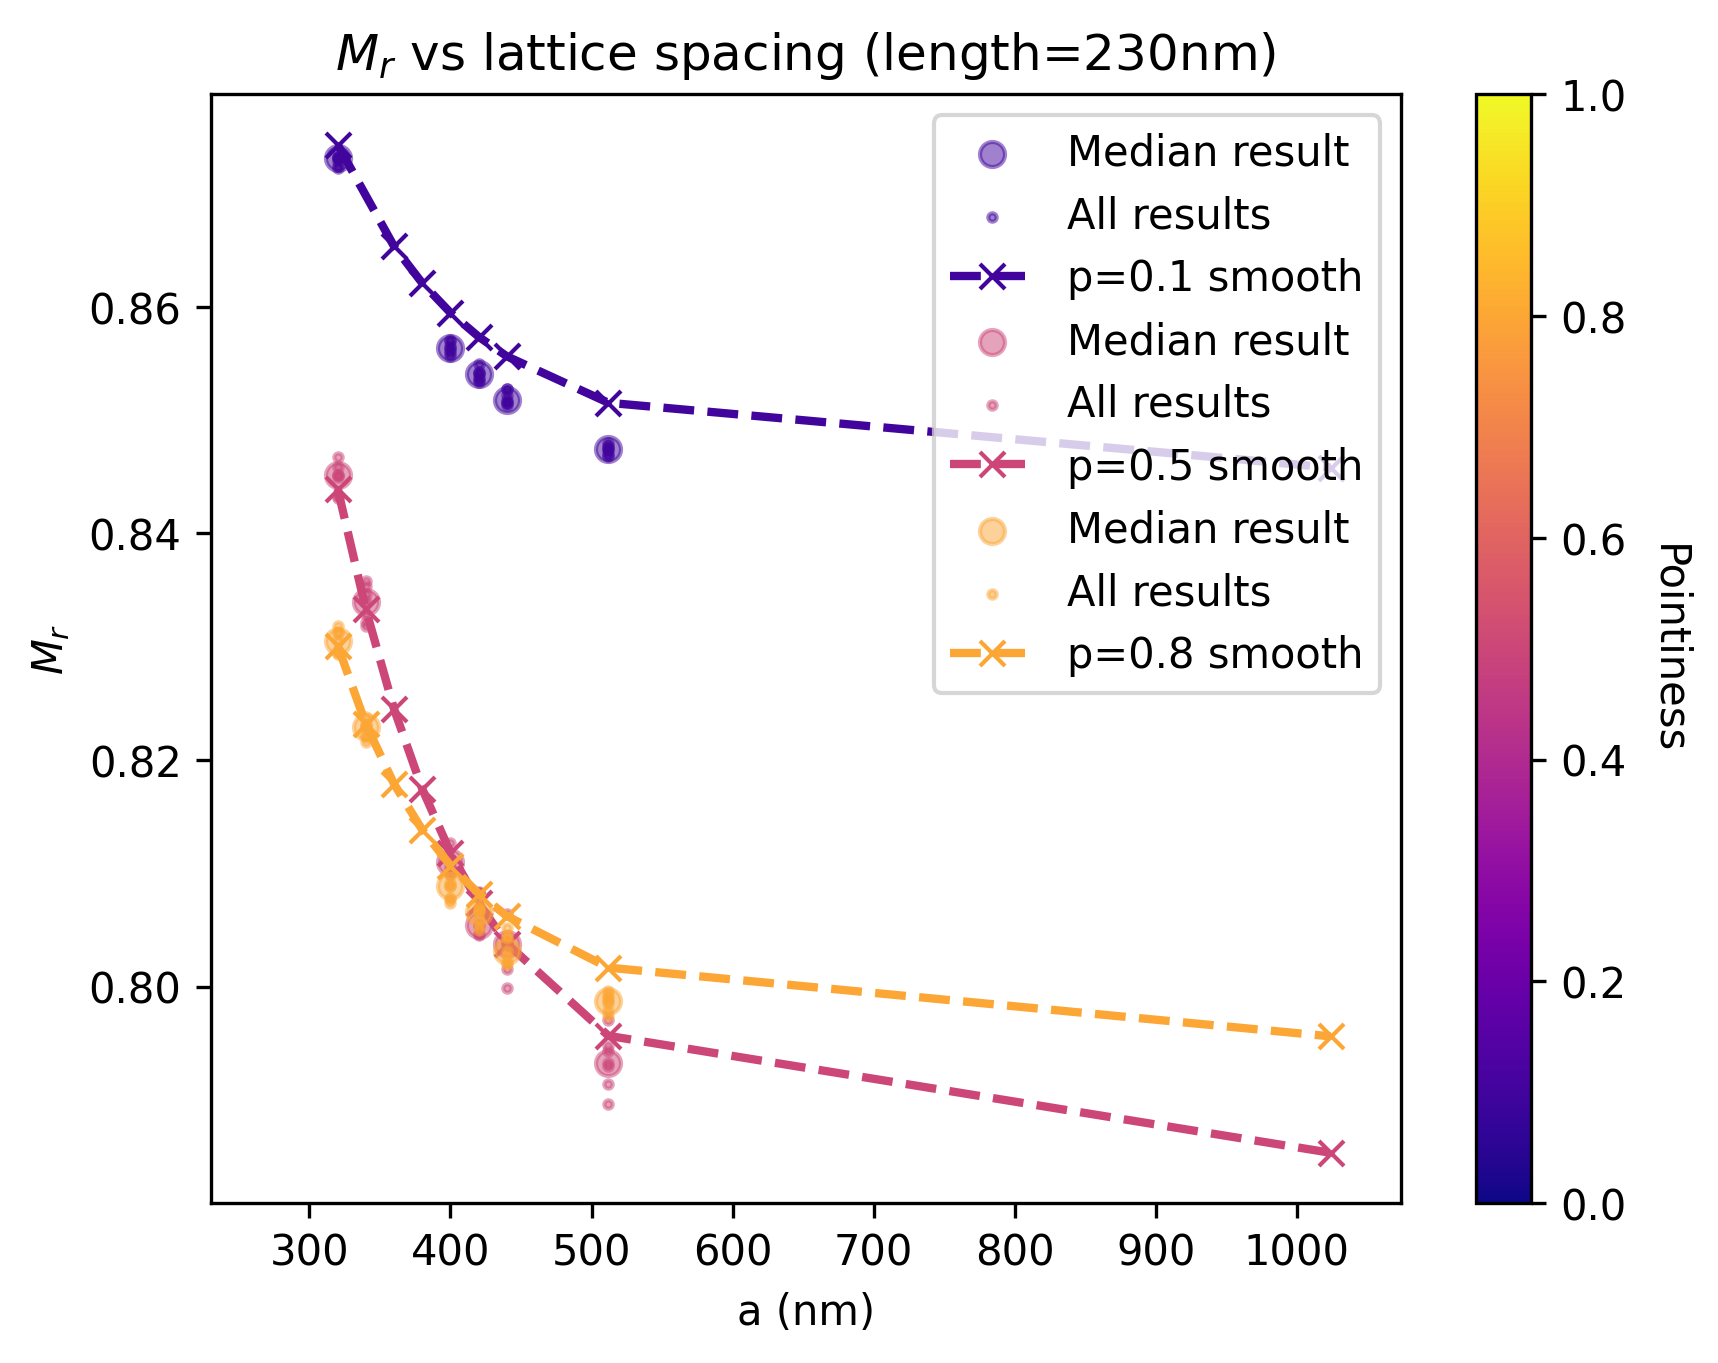

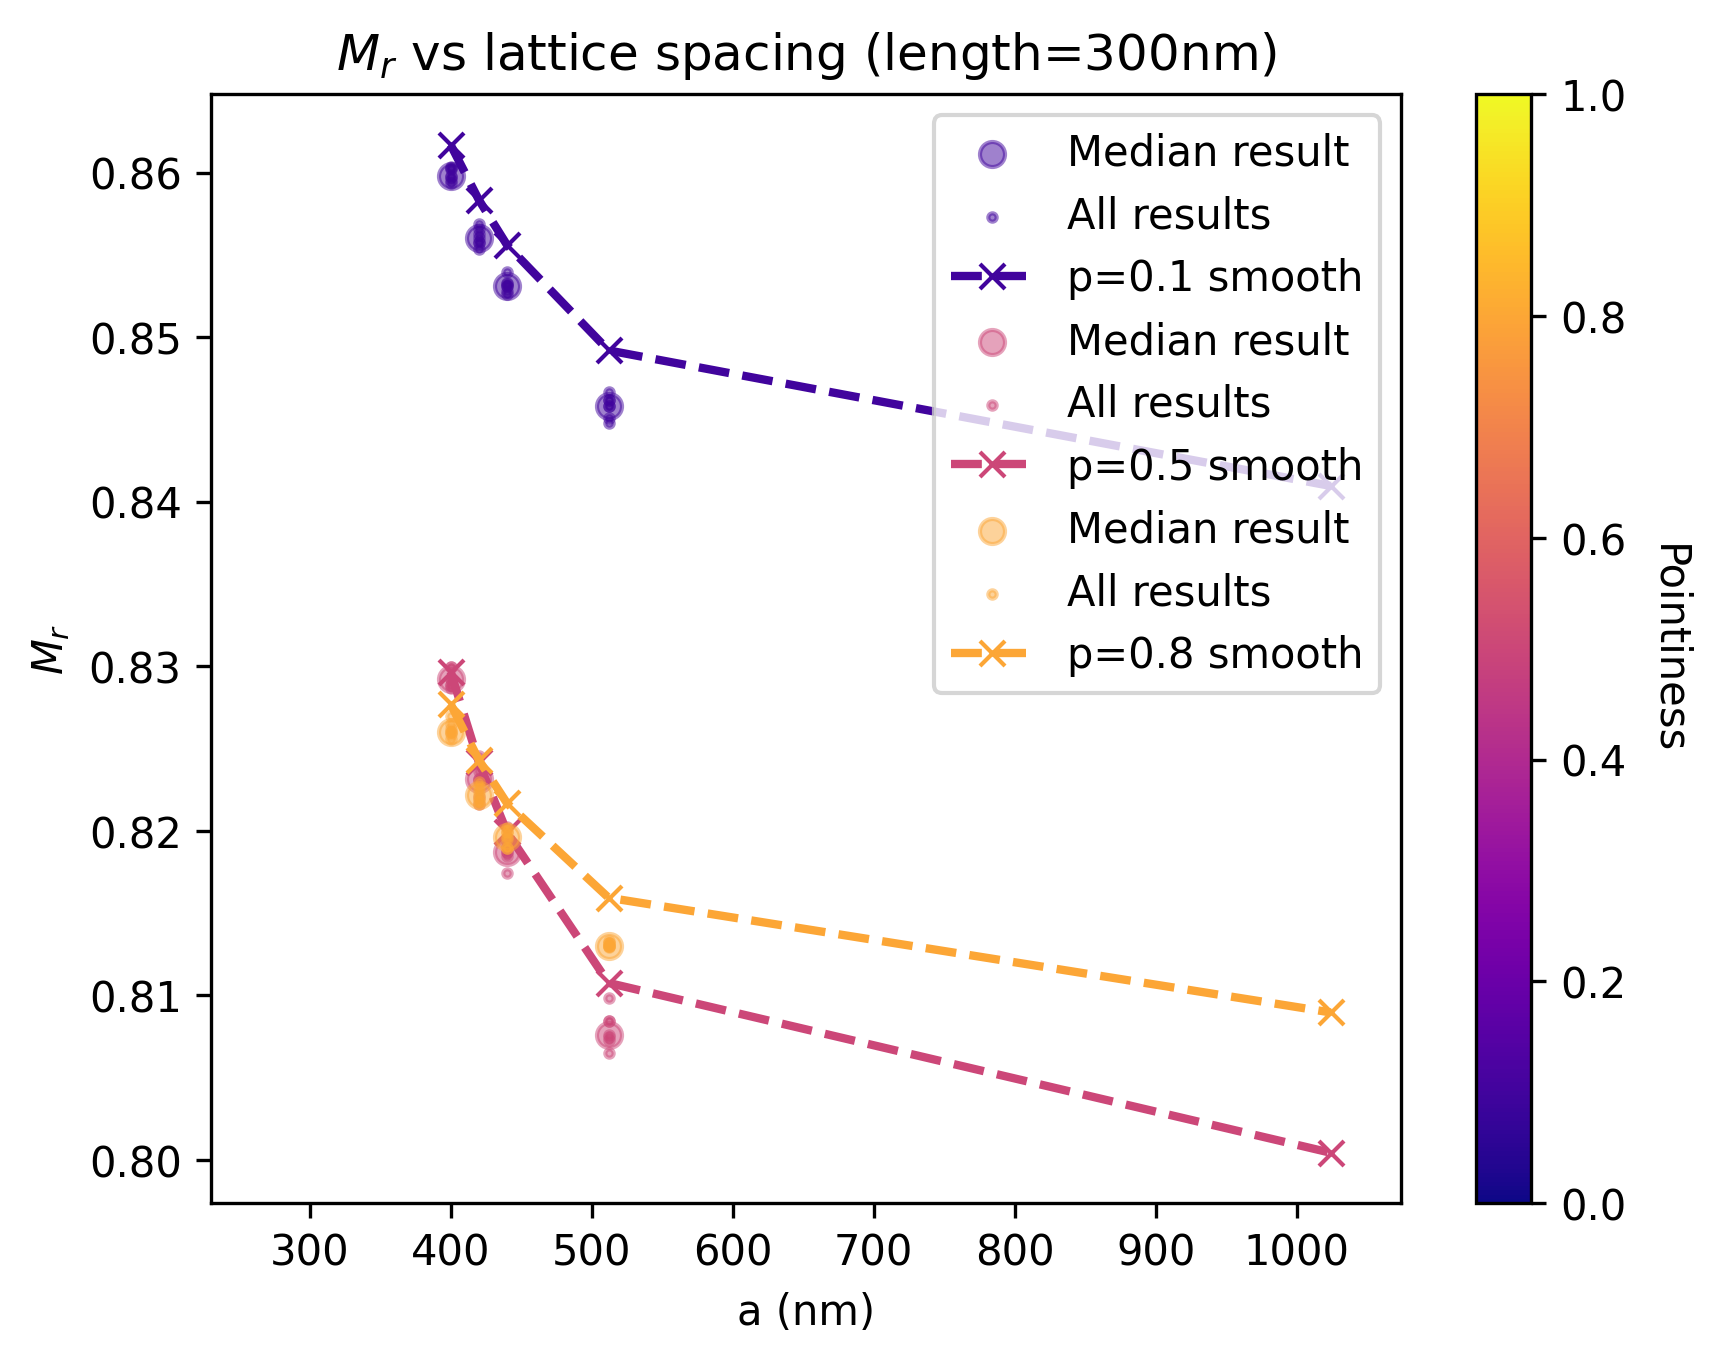

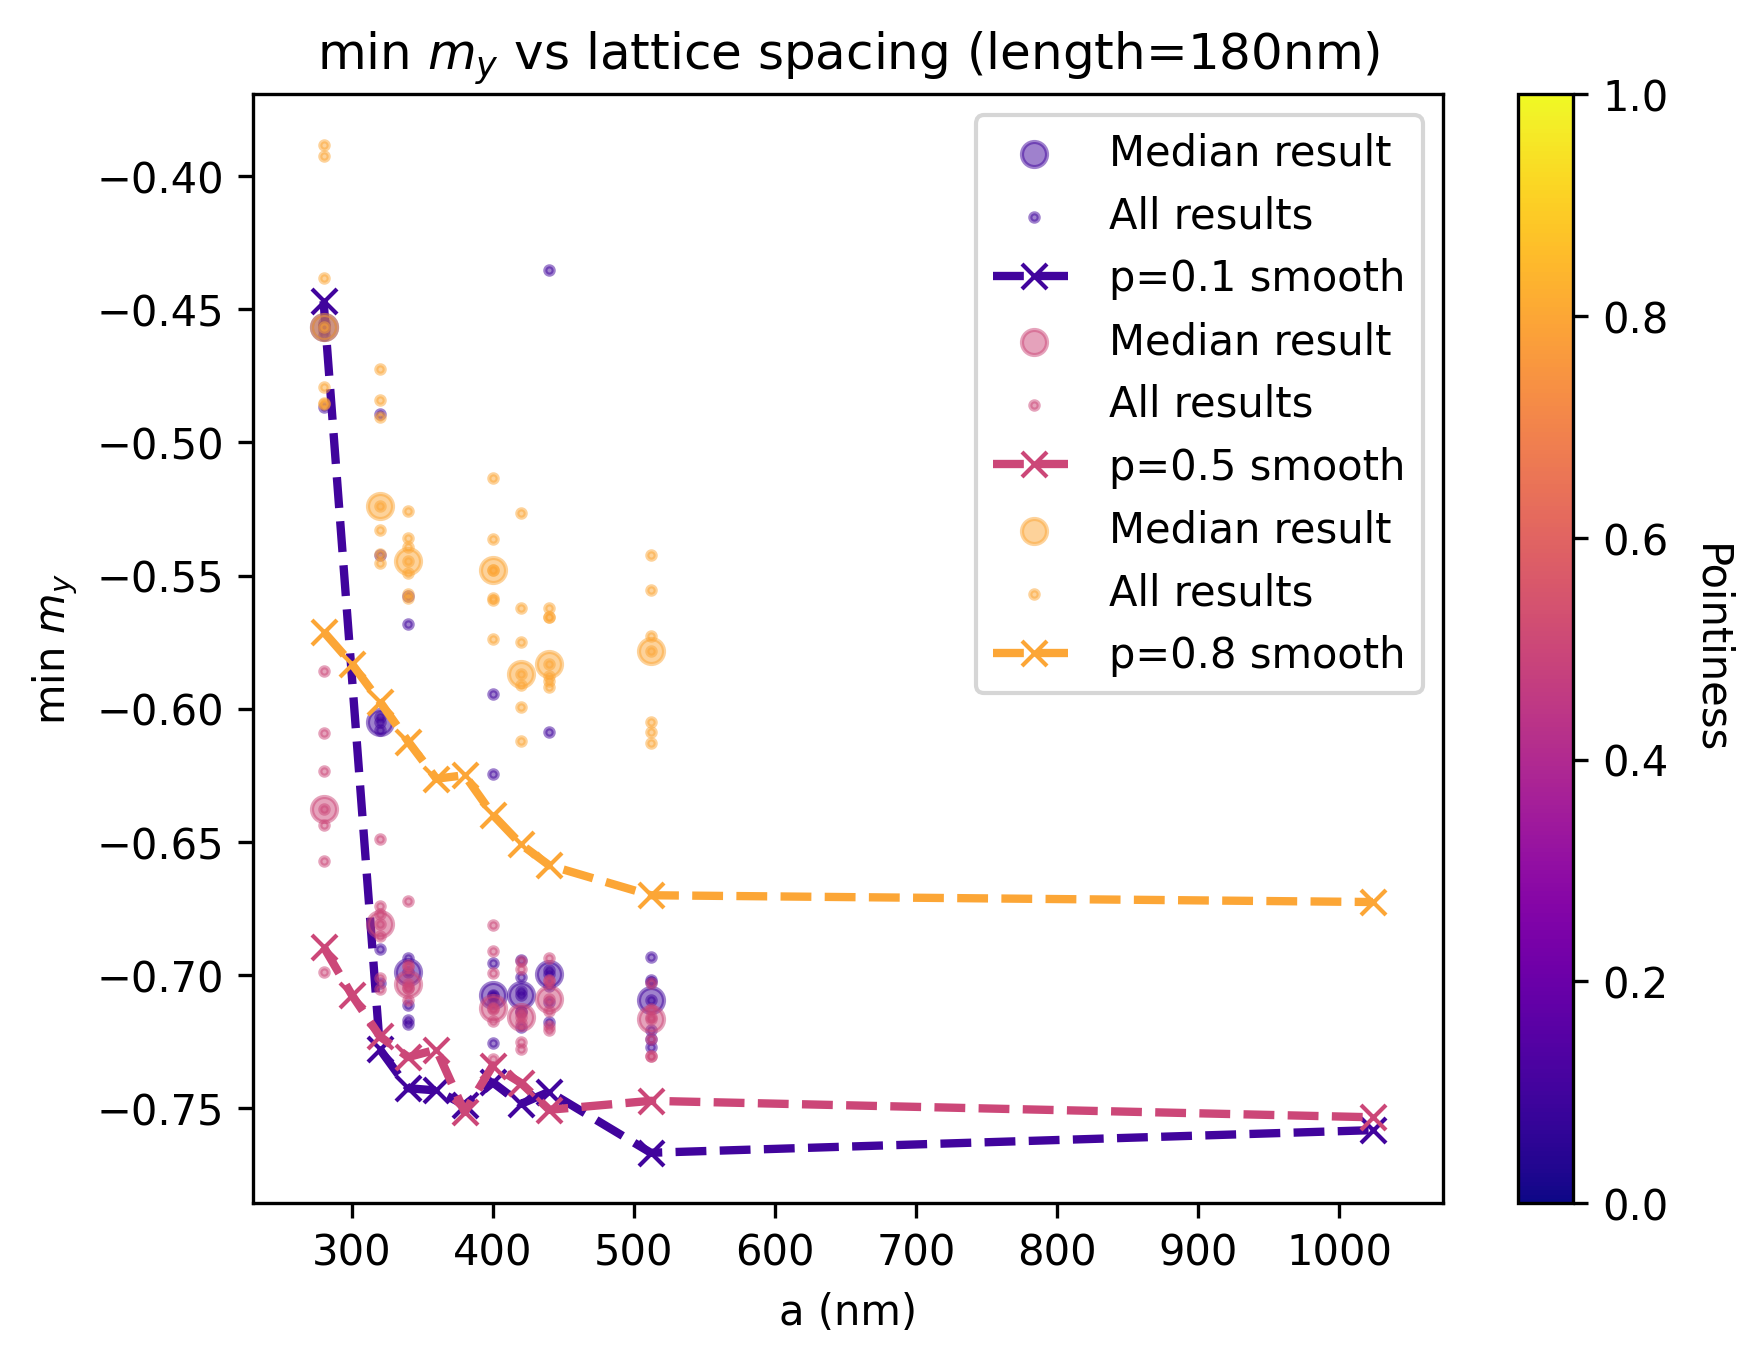

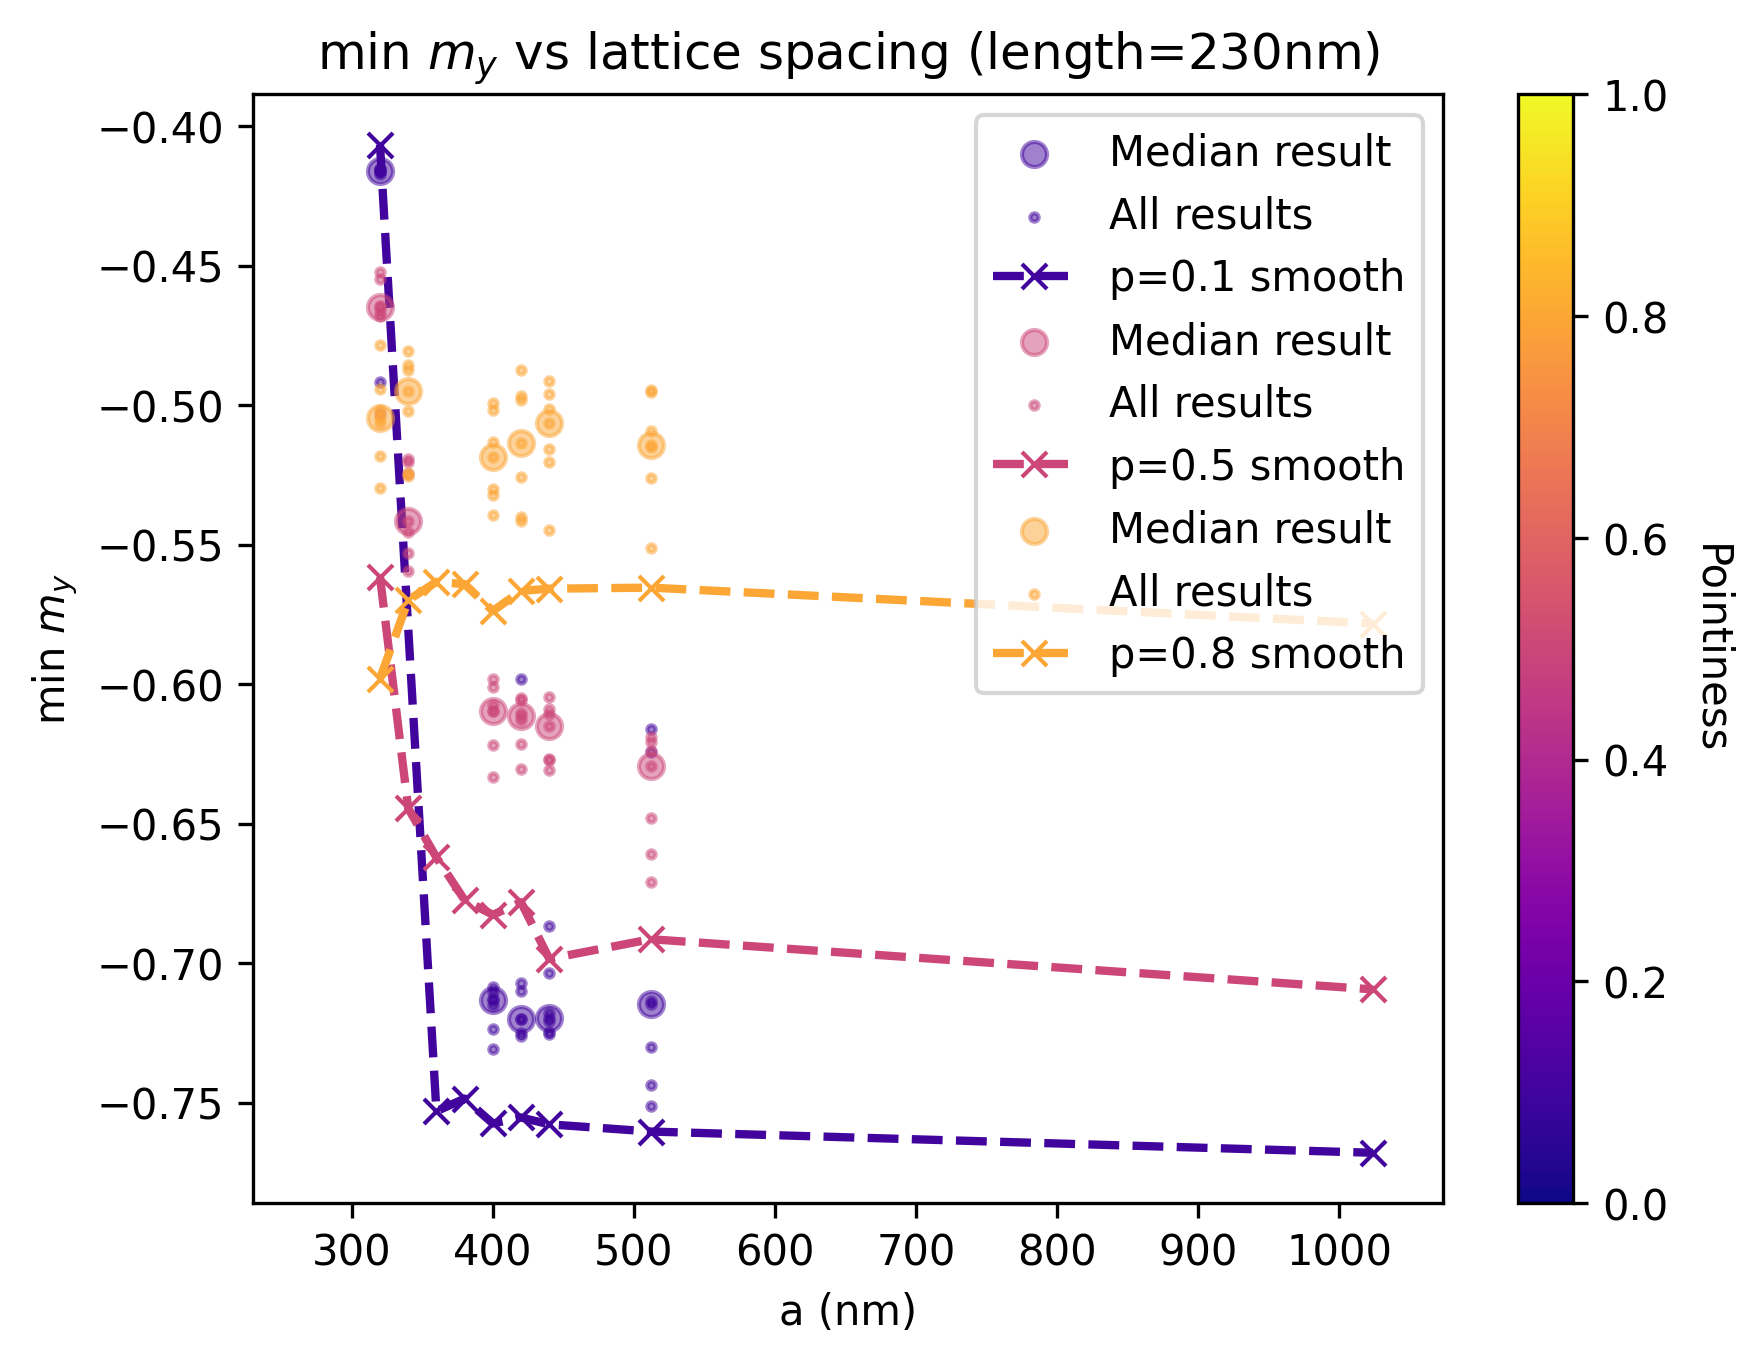

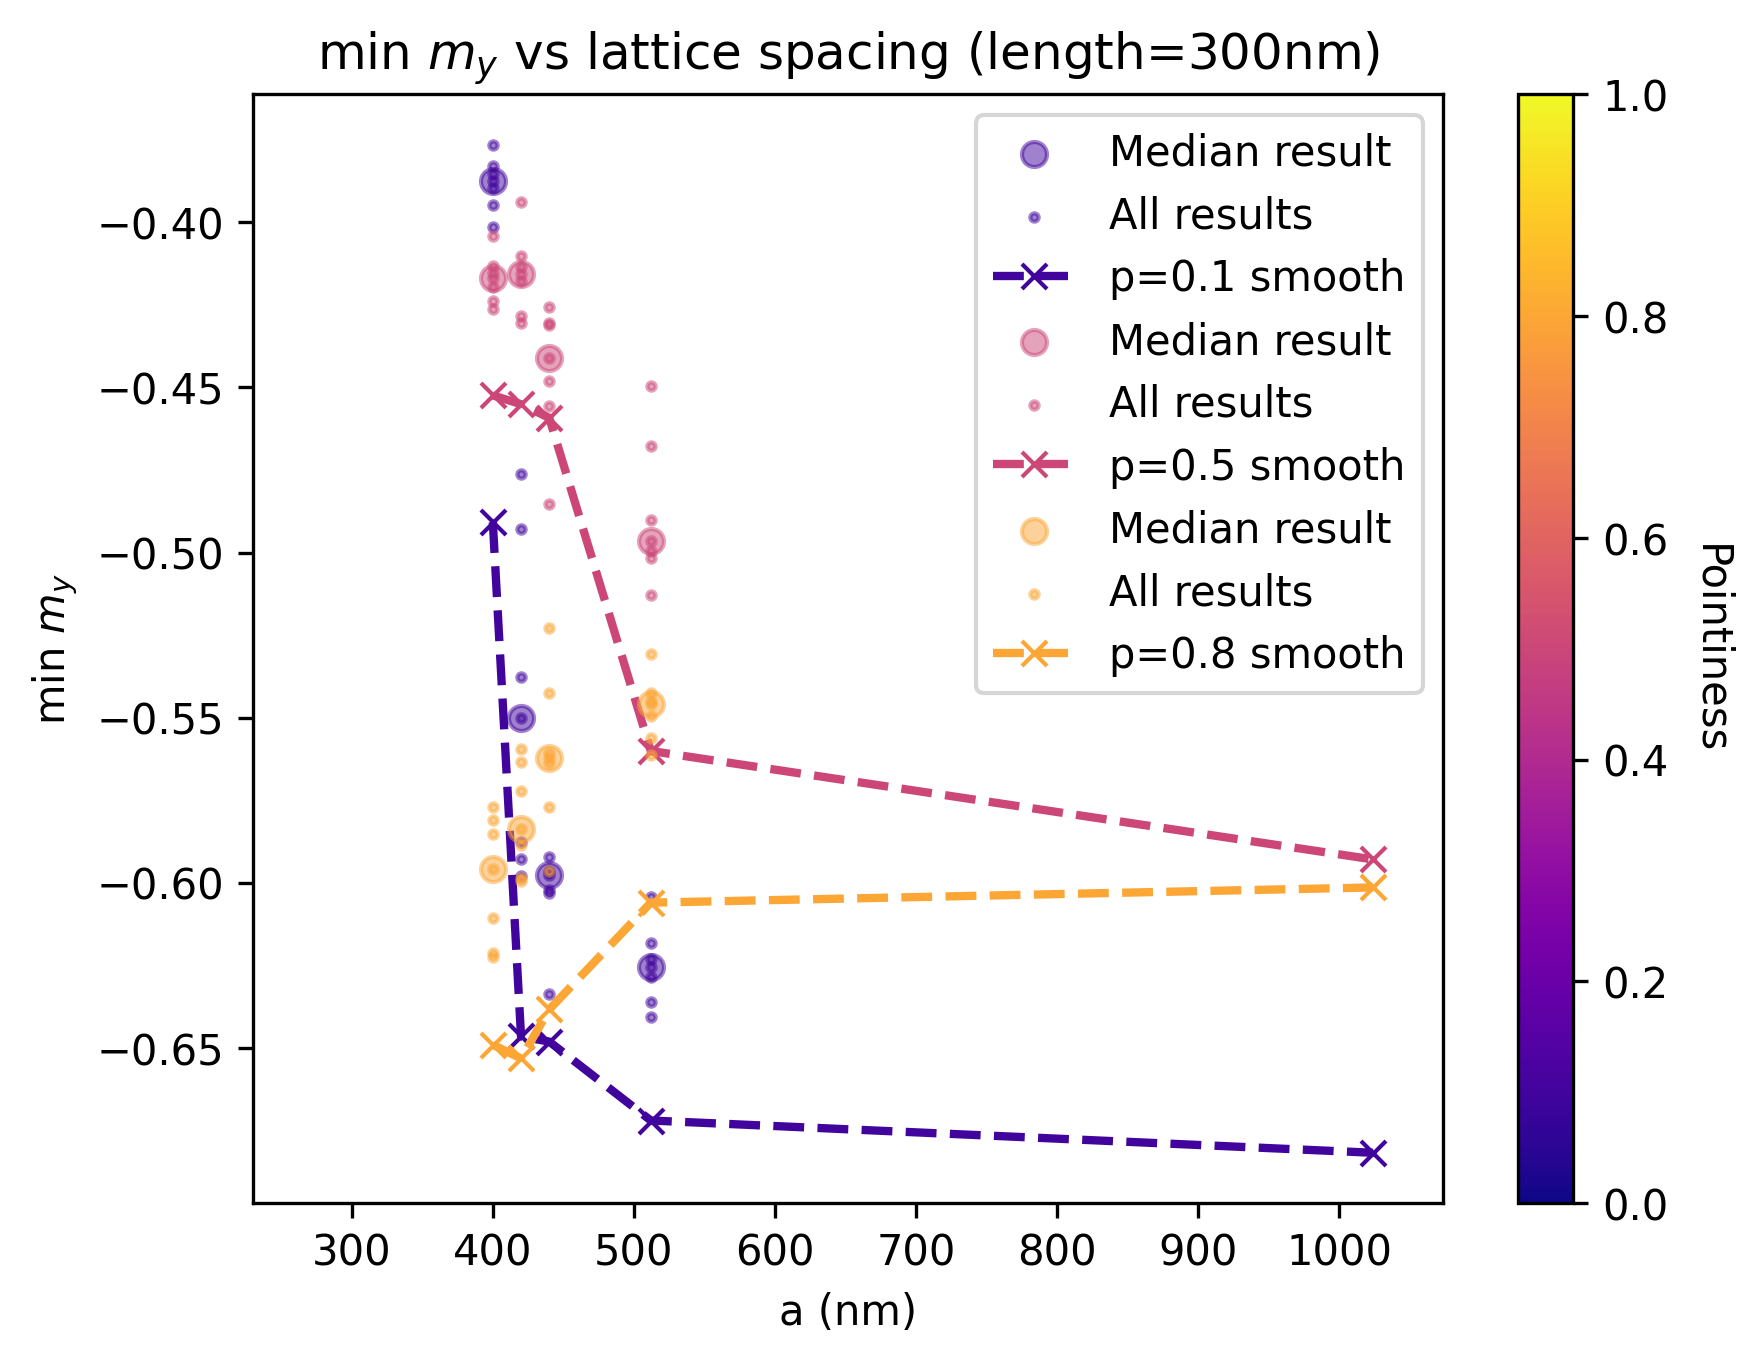

In [9]:
mpl.rcParams['figure.dpi'] = 300

useMedian=True

def makePlot(lengthVal,plotFunction,plotValue):
    colors=plt.cm.plasma(roughPointinessVals)
    usedPointinesses=set()
    for i,pointiness in enumerate(roughPointinessVals):
        Hc=[]
        spacings=[]
        blackX=[]
        blackY=[]
        
        #print(pointiness - 80/(1e9*lengthVal), 80/(1e9*lengthVal), pointiness)

        thisLegendMade=False
        for spacing in spacingVals:
            
            thisRuns=getRuns(spacing,pointiness,lengthVal,data)
            if len(thisRuns)==0:
                continue
            
            

            usedPointinesses.add(pointiness)
            thisRun=thisRuns[0]
            Hc.append(plotFunction(thisRun))
            spacings.append(spacing*1e9)

            
            
            if abs(pointiness - 80/(1e9*lengthVal)) < 0.01:
                
                blackX.append(spacing*1e9)
                blackY.append(plotFunction(thisRun))
                #print(blackX)

            roughRuns = getRuns(spacing,pointiness,lengthVal,roughData)
            if len(roughRuns)>0:
                Hcs = [plotFunction(run) for run in roughRuns]

                if useMedian:
                    low=np.min(Hcs)
                    high=np.max(Hcs)
                    median=np.median(Hcs)

                    if(thisLegendMade==False and len(Hcs)>0):
                        plt.scatter(spacings[-1],median,color=colors[i],marker="o",label="Median result",alpha=0.5)
                        plt.scatter([spacings[-1]]*len(Hcs),Hcs,color=colors[i],s=4,label="All results",alpha=0.5)
                        thisLegendMade=True
                    else:
                        plt.scatter(spacings[-1],median,color=colors[i],marker="o",alpha=0.5)
                        plt.scatter([spacings[-1]]*len(Hcs),Hcs,color=colors[i],s=4,alpha=0.5)
                    


                else:
                    if(thisLegendMade==False and len(Hcs)>0):
                        plt.scatter([spacings[-1]]*len(Hcs),Hcs,color=colors[i],label=f"p={pointiness} rough")
                        thisLegendMade=True
                    else: 
                        plt.scatter([spacings[-1]]*len(Hcs),Hcs,color=colors[i])
                #plt.plot([spacings[-1]]*2,[min(Hcs),max(Hcs)],color=colors[i])
                #plt.errorbar(spacings[-1],Hc[-1],color=colors[i],yerr=(max(Hcs)-min(Hcs))/2,zorder=1e9,capsize=6)

        #plt.scatter(blackX,blackY,color="k",s=8,zorder=i+0.5)
        plt.plot(spacings,Hc,"--x",color=colors[i],linewidth=2,zorder=i,label=f"p={pointiness} smooth")
        
        
    cbar=plt.colorbar(mpl.cm.ScalarMappable(cmap="plasma"))
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('Pointiness', rotation=270)
    #for pointiness in list(usedPointinesses):
    #    cbar.ax.plot([0, 1], [pointiness,pointiness], 'k') 

    plt.title(f"{plotValue} vs lattice spacing (length={round(lengthVal*1e9)}nm)")
    plt.xlabel("a (nm)")
    plt.ylabel(plotValue)
    plt.xlim(min(spacingVals)*1e9-50,max(spacingVals)*1e9+50)


    plt.legend(loc=1)
    plt.show()
    
for lengthVal in lengthVals:
    if lengthVal in roughLengthVals:
        makePlot(lengthVal,lambda run:run.attrs["Hc"],plotValue="$H_c$")

for lengthVal in lengthVals:
    if lengthVal in roughLengthVals:
        makePlot(lengthVal,lambda run:run.attrs["Br"],plotValue="$M_r$")

for lengthVal in lengthVals:
    if lengthVal in roughLengthVals:
        makePlot(lengthVal,lambda run:np.min(run["hIsland_my"]),plotValue="min $m_y$")

<ErrorbarContainer object of 3 artists>

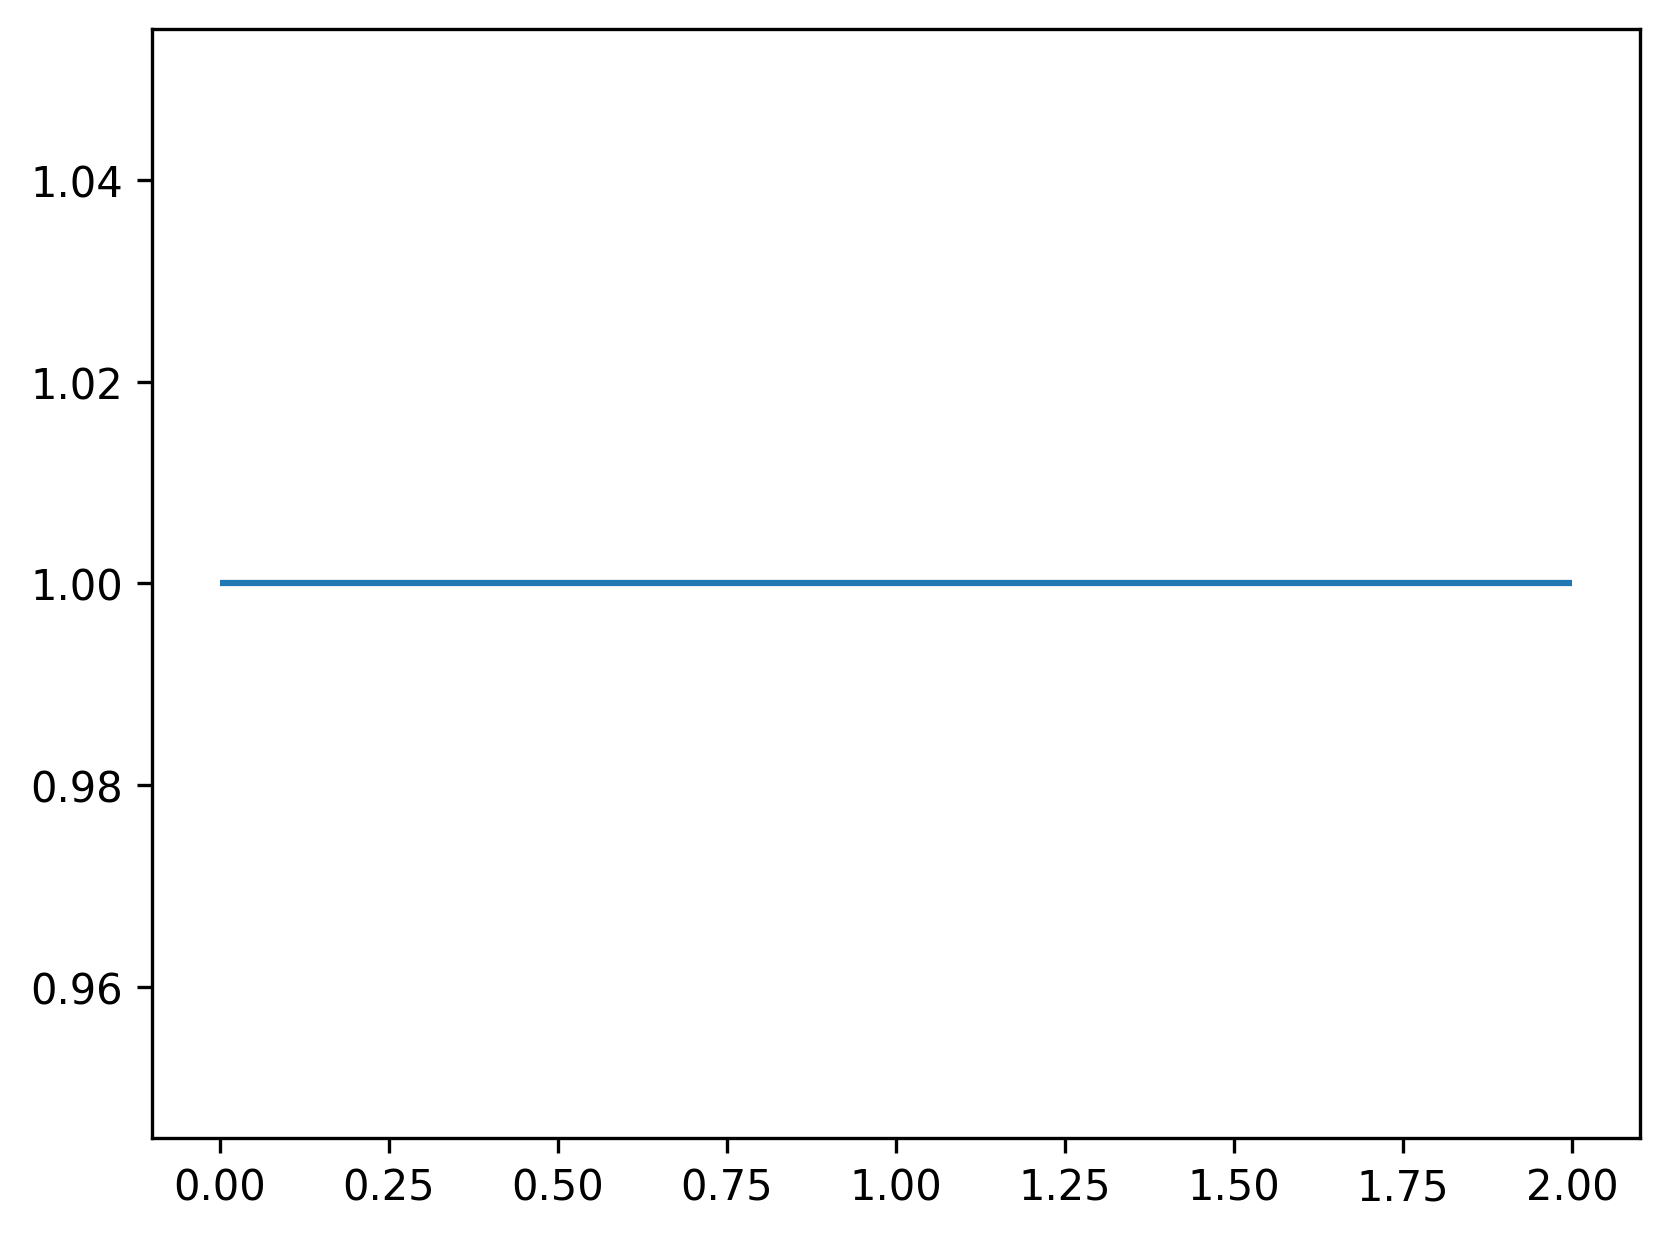